In [1]:
import pandas as pd
import random
import numpy as np
from random import randint

import torch
from transformers import AutoTokenizer, AutoModel
# import adapters
# from adapters import AutoAdapterModel
# from sentence_transformers import SentenceTransformer
import gc
# import cohere
from tqdm.notebook import tqdm
# import tiktoken
# from openai import OpenAI

import scipy as sp
from scipy import sparse
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from openTSNE import TSNE, affinity

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import glasbey

import time
import pickle
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import distro

%load_ext watermark

In [2]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append(
    "/gpfs01/berens/user/rgonzalesmarquez/phd/iclr-dataset/scripts"
)  # MANUAL FIX TO PATH ISSUE FROM VSCODE

from embeddings import generate_embeddings
from plotting import plot_tsne_colors, plot_label_tags

In [3]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [5]:
variables_path = Path("../results/variables/iclr26v1")
figures_path = Path("../results/figures")
data_path = Path("../data")

In [6]:
pwd

'/gpfs01/berens/user/rgonzalesmarquez'

In [7]:
# MANUAL FIX TO PATH ISSUE FROM VSCODE
nb_path = Path("phd/iclr-dataset/scripts")
assert nb_path.exists(), "The path does not exist"

variables_path = (nb_path / variables_path).resolve(strict=True)
figures_path = (nb_path / figures_path).resolve(strict=True)
data_path = (nb_path / data_path).resolve(strict=True)

In [8]:
plt.style.use((nb_path / Path("matplotlib_style.txt")).resolve(strict=True))

In [9]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2025-11-17 11:01:27CET

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.31.0

transformers: 4.45.2

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 4.18.0-553.el8_10.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

seaborn        : 0.13.2
tqdm           : 4.66.4
scipy          : 1.11.4
sys            : 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:12:24) [GCC 11.2.0]
glasbey        : 0.2.1
torch          : 2.5.0
pandas         : 2.2.3
jupyter_black  : 0.4.0
numpy          : 1.26.4
distro         : 1.9.0
openTSNE       : 1.0.2
sklearn        : 1.5.2
matplotlib     : 3.9.2
transformers   : 4.45.2
black          : 24.10.0
memory_profiler: 0.61.0

Watermark: 2.5.0

Ubuntu 24.04 LTS


# Import

In [10]:
%%time
iclr = pd.read_parquet(
    data_path / "iclr26v1.parquet",
    engine="fastparquet",
)

CPU times: user 179 ms, sys: 81.2 ms, total: 260 ms
Wall time: 324 ms


In [11]:
iclr

,year,id,title,abstract,authors,author_ids,decision,scores,keywords,labels
0,2017,B1-Hhnslg,Prototypical Networks for Few-shot Learning,A recent approach to few-shot classification c...,"Jake Snell, Kevin Swersky, Richard Zemel",,Reject,"[6, 4, 5]","[deep learning, transfer learning]",transfer learning
1,2017,B1-q5Pqxl,Machine Comprehension Using Match-LSTM and Ans...,Machine comprehension of text is an important ...,"Shuohang Wang, Jing Jiang",,Accept (Poster),"[6, 6, 7]","[natural language processing, deep learning]",language models
2,2017,B16Jem9xe,Learning in Implicit Generative Models,Generative adversarial networks (GANs) provide...,"Shakir Mohamed, Balaji Lakshminarayanan",,Invite to Workshop Track,"[8, 7, 6]",[unsupervised learning],unlabeled
3,2017,B16dGcqlx,Third Person Imitation Learning,Reinforcement learning (RL) makes it possible ...,"Bradly C Stadie, Pieter Abbeel, Ilya Sutskever",,Accept (Poster),"[6, 5, 6]",[],unlabeled
4,2017,B184E5qee,Improving Neural Language Models with a Contin...,We propose an extension to neural network lang...,"Edouard Grave, Armand Joulin, Nicolas Usunier",,Accept (Poster),"[7, 9, 5]",[natural language processing],language models
...,...,...,...,...,...,...,...,...,...,...
55901,2026,zz3El6hqbs,Learning activation functions with PCA on a se...,This work explores a novel approach to learnin...,,,,[],"[deep neural networks, activation function lea...",unlabeled
55902,2026,zzJTo7ujql,Phased DMD: Few-step Distribution Matching Dis...,Distribution Matching Distillation (DMD) disti...,,,,[],"[diffusion models, distribution matching, dist...",diffusion models
55903,2026,zzTDulLys0,vAttention: Verified Sparse Attention via Samp...,State-of-the-art sparse attention methods for ...,,,,[],[sparse attention],unlabeled
55904,2026,zzTQISAGUp,Polychromic Objectives for Reinforcement Learning,Reinforcement learning fine-tuning (RLFT) is a...,,,,[],"[reinforcement learning, exploration]",RL


In [12]:
print(iclr.shape)
print(len(iclr.abstract.to_list()))

(55906, 10)
55906


In [13]:
labels_iclr = iclr.labels.to_numpy()
len(np.unique(labels_iclr))

55

In [14]:
pickle_in = open(
    variables_path / "dict_label_to_color.pkl",
    "rb",
)
dict_label_to_color = pickle.load(pickle_in)

In [15]:
len(dict_label_to_color)

55

In [16]:
colors_iclr = np.vectorize(dict_label_to_color.get)(labels_iclr)

# Obtain representation

## SBERT

### General pipeline

In [17]:
model_names = [
    "SBERT",
]

model_paths = [
    "sentence-transformers/all-mpnet-base-v2",
]
print(model_names)

['SBERT']


In [18]:
%%time
for i, model_name in enumerate(model_names):
    # set up model
    print("Model: ", model_name)

    random_state = random.seed(42)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    model = model.to(device)

    # get embeddings
    embedding_cls, embedding_sep, embedding_av = generate_embeddings(
        iclr.abstract.to_list(), tokenizer, model, device, batch_size=182
    )

    # save embeddings
    saving_path = Path("embeddings_" + model_name.lower())
    (variables_path / saving_path).mkdir(exist_ok=True)

    np.save(
        variables_path / saving_path / "embedding_abstracts_only_cls",
        embedding_cls,
    )
    np.save(
        variables_path / saving_path / "embedding_abstracts_only_sep",
        embedding_sep,
    )
    np.save(
        variables_path / saving_path / "embedding_abstracts_only_av",
        embedding_av,
    )

    model = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  SBERT
Running on device: cuda
sentence-transformers/all-mpnet-base-v2


  0%|          | 0/308 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 11min 50s, sys: 41.8 s, total: 12min 32s
Wall time: 7min 58s


# t-SNE

In [ ]:
%%time
for i, model_name in enumerate(model_names):
    # import
    saving_path = Path("embeddings_" + model_name.lower())

    embedding_av = np.load(
        variables_path / saving_path / "embedding_abstracts_only_av.npy"
    )

    if model_name != "ST5":
        embedding_cls = np.load(
            variables_path / saving_path / "embedding_abstracts_only_cls.npy"
        )
        embedding_sep = np.load(
            variables_path / saving_path / "embedding_abstracts_only_sep.npy"
        )

        # t-SNE
        tsne_cls = TSNE(verbose=True, random_state=42).fit(embedding_cls)
        tsne_sep = TSNE(verbose=True, random_state=42).fit(embedding_sep)

    tsne_av = TSNE(verbose=True, random_state=42).fit(embedding_av)

    # save
    if model_name != "ST5":
        np.save(variables_path / saving_path / "tsne_cls.npy", tsne_cls)
        np.save(variables_path / saving_path / "tsne_sep.npy", tsne_sep)
    np.save(variables_path / saving_path / "tsne_av.npy", tsne_av)

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 191.76 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.70 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.50 seconds
===> Running optimization with exaggeration=12.00, lr=4658.83 for 250 iterations...
Iteration   50, KL divergence 6.5429, 50 iterations in 5.4053 sec
Iteration  100, KL divergence 6.6307, 50 iterations in 5.3928 sec
Iteration  150, KL divergence 6.6304, 50 iterations in 5.4134 sec
Iteration  200, KL divergence 6.6313, 50 iterations in 5.4393 sec
Iteration  250, KL divergence 6.6301, 50 iterations in 5.4097 sec
   --> Time elapsed: 27.06 seconds
===> Running optimization with exaggeration=1.00, lr

In [27]:
tsne_av.shape

(36113, 2)

## Plot

/gpfs01/berens/user/rgonzalesmarquez/phd/iclr-dataset/scripts/plotting.py:335: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot([x[i],center_cluster_coordinates_left.x[i]],[y[i],center_cluster_coordinates_left.y[i]], c=colr, linewidth=0.4, clip_on=False)
/gpfs01/berens/user/rgonzalesmarquez/phd/iclr-dataset/scripts/plotting.py:351: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot([x[i],center_cluster_coordinates_right.x[i]],[y[i],center_cluster_coordinates_right.y[i]], c=colr, linewidth=0.4, clip_on=False)


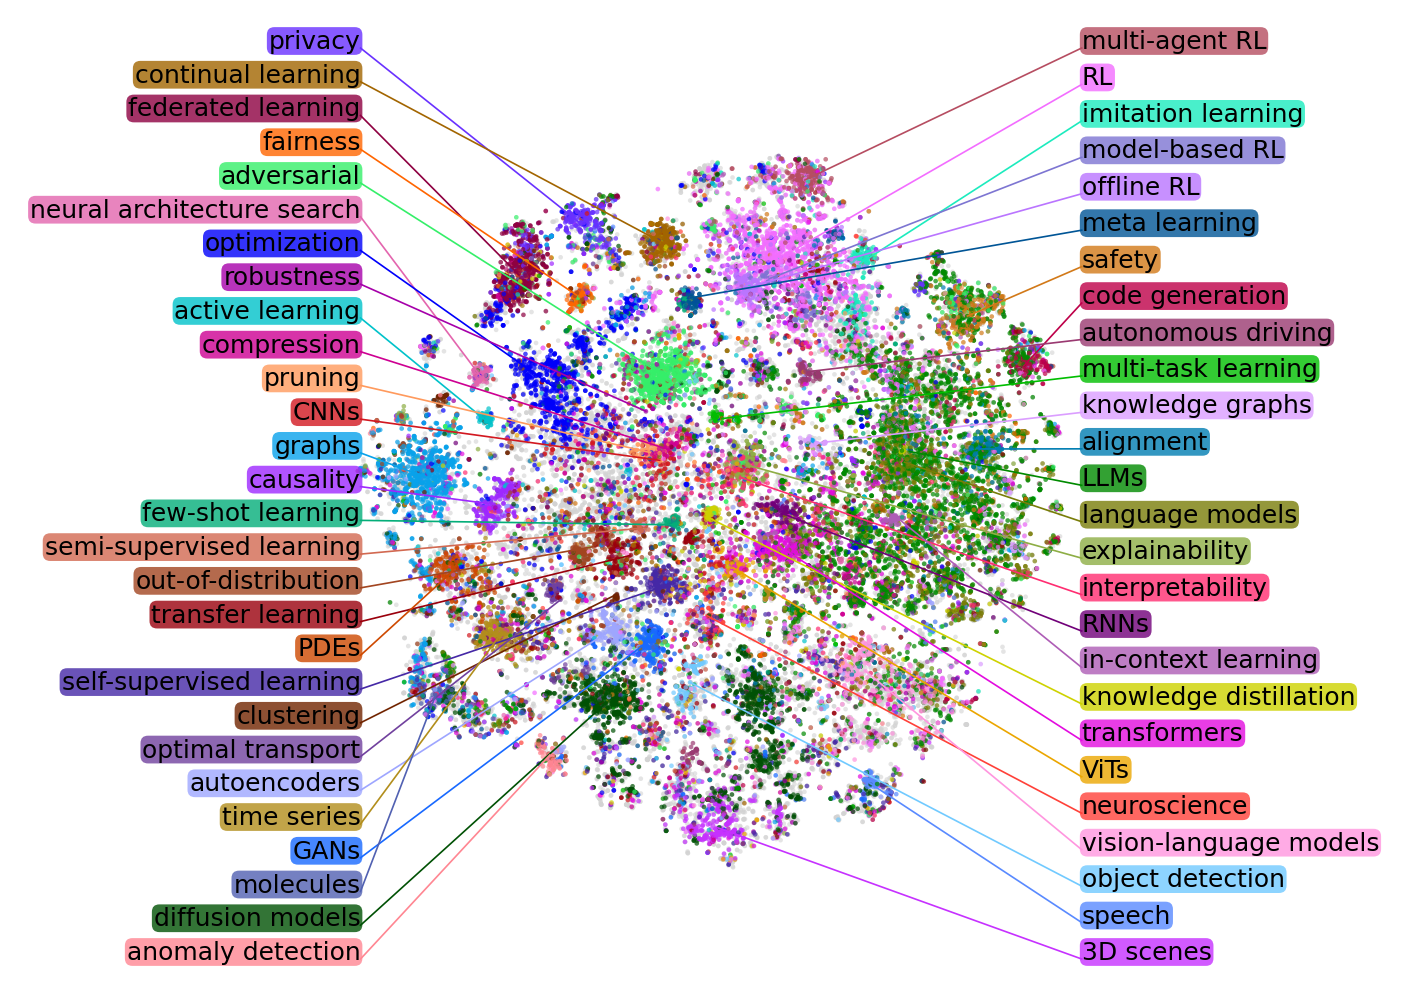

In [20]:
fig, ax = plt.subplots(figsize=(5, 3.2), dpi=300, layout="constrained")

xlim = (-95, 95)
ylim = (-95, 95)

model_name = "SBERT"
# load
saving_path = Path("embeddings_" + model_name.lower())
tsne_av = np.load(variables_path / saving_path / "tsne_av.npy")

plot_tsne_colors(
    tsne_av,
    colors_iclr,
    ax=ax,
    # plot_type="subplot_3",
)
plot_label_tags(
    tsne_av,
    colors_iclr,
    dict_label_to_color,
    x_lim=xlim,
    y_lim=(-120, 120),
    ax=ax,
    subset=False,
    fontsize=6,
    capitalize=False,
    middle_value=-10,
)

fig.savefig(figures_path / "tmp" / "tsne_embedding_sbert_iclr26v1_v1.png")